In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

# PyTorch TensorBoard support
# from torch.utils.tensorboard import SummaryWriter
# !pip install tensorboardX
# from tensorboardX import SummaryWriter
from datetime import datetime


transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

# Create datasets for training & validation, download if necessary
training_set = torchvision.datasets.CIFAR10('./data', train=True, transform=transform, download=True)
validation_set = torchvision.datasets.CIFAR10('./data', train=False, transform=transform, download=True)

# Create data loaders for our datasets; shuffle for training, not for validation
training_loader = torch.utils.data.DataLoader(training_set, batch_size=64, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=64, shuffle=False)

# Class labels
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Report split sizes
print('Training set has {} instances'.format(len(training_set)))
print('Validation set has {} instances'.format(len(validation_set)))

100%|██████████| 170498071/170498071 [00:02<00:00, 60875229.59it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Training set has 50000 instances
Validation set has 10000 instances


cat  truck  horse  plane


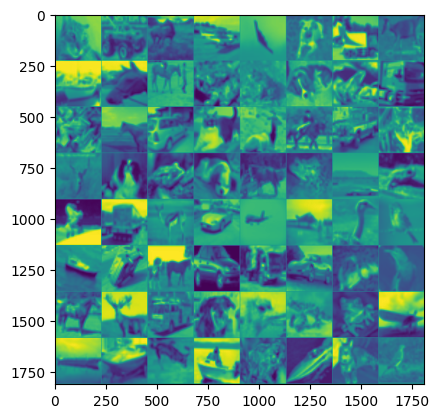

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# Helper function for inline image display
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg)
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

dataiter = iter(training_loader)
images, labels = next(dataiter)

# Create a grid from the images and show them
img_grid = torchvision.utils.make_grid(images)
matplotlib_imshow(img_grid, one_channel=True)
print('  '.join(classes[labels[j]] for j in range(4)))

In [3]:
def plot_graph(history):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_figwidth(10)
    fig.suptitle("Train vs Validation")
    ax1.plot(history["train_acc"], label="Train")
    ax1.plot(history["validate_acc"], label="Validation")
    ax1.legend()
    ax1.set_title("Accuracy")

    ax2.plot(history["train_loss"], label="Train")
    ax2.plot(history["validate_loss"], label="Validation")
    ax2.legend()
    ax2.set_title("Loss")
    fig.show()

In [ ]:
# 1.1 Conv-Conv-Pool
import os
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
import time

#---Variable initialization---
torch.manual_seed(42)
#-----------------------------

# PyTorch models inherit from torch.nn.Module
#---CNN---
class DeepModel(nn.Module):
    def __init__(self):
        super(DeepModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3, stride=1, padding=1)  # 3x224x224 -> 10x224x224
        self.conv2 = nn.Conv2d(in_channels=10, out_channels=10, kernel_size=3, stride=1, padding=1)  # 10x224x224 -> 10x224x224
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # 10x224x224 -> 10x112x112
        self.conv3 = nn.Conv2d(in_channels=10, out_channels=20, kernel_size=3, stride=1, padding=1)  # 10x112x112 -> 20x112x112
        self.conv4 = nn.Conv2d(in_channels=20, out_channels=20, kernel_size=3, stride=1, padding=1)  # 20x112x112 -> 20x112x112

        # Fully connected layers
        self.fc1 = nn.Linear(20 * 56 * 56, 45)
        self.fc2 = nn.Linear(45, 45)
        self.fc3 = nn.Linear(45, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv2(self.conv1(x)))) # 3x224x224 -> 10x224x224 -> 10x112x112
        x = self.pool(F.relu(self.conv4(self.conv3(x)))) # 10x112x112 -> 20x112x112 -> 20x56x56
        x = x.view(-1, 20 * 56 * 56) #[bs, 180] (bs = Batch Size = 32 or 64 or ...)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Model init
model = DeepModel()
summary(model, (3, 224, 224))

# Loss function
loss_fn = torch.nn.CrossEntropyLoss()
# Optimizers specified in the torch.optim package
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Initializing in a separate cell so we can easily add more epochs to the same run
# timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
# writer = SummaryWriter('runs/fashion_trainer_{}'.format(timestamp))
epoch_number = 0

EPOCHS = 5
path_save_cp = './cp/'
best_vloss = 1_000_000.
training_logs = {"train_loss": [],  "train_acc": [], "validate_loss": [], "validate_acc": []}

t_0_nonaccelerated = time.time()
for epoch in range(EPOCHS):
    train_loss, train_correct = 0, 0
    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate(training_loader):
        # Every data instance is an input + label pair
        inputs, labels = data

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs)

        # Compute the loss and its gradients
        loss = loss_fn(outputs, labels)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        train_loss += loss.item()
        train_correct += (outputs.argmax(1) == labels).float().sum().item()

    training_logs["train_loss"].append(train_loss / len(training_loader))
    training_logs["train_acc"].append(train_correct / len(training_loader.dataset))

    running_vloss = 0.0
    # Set the model to evaluation mode, disabling dropout and using population
    # statistics for batch normalization.
    model.eval()
    # Disable gradient computation and reduce memory consumption.
    valid_loss, valid_correct = 0, 0
    with torch.no_grad():
        for i, vdata in enumerate(validation_loader):
            vinputs, vlabels = vdata
            voutputs = model(vinputs)
            vloss = loss_fn(voutputs, vlabels)
            valid_loss += loss_fn(voutputs, vlabels).item()
            valid_correct += (voutputs.argmax(1) == vlabels).float().sum().item()
        # save validation logs
        training_logs["validate_loss"].append(valid_loss / len(validation_loader))
        training_logs["validate_acc"].append(valid_correct / len(validation_loader.dataset))

    if epoch % 1 == 0:
        print(f"Epochs {epoch+1}".ljust(10),
            f"train loss {training_logs['train_loss'][-1]:.5f}",
            f"train acc {training_logs['train_acc'][-1]:.5f}",

            f"validate loss {training_logs['validate_loss'][-1]:.5f}",
            f"validate acc {training_logs['validate_acc'][-1]:.5f}",
            )
        print("-"*80)

    # Track best performance, and save the model's state
    if valid_loss < best_vloss:
        best_vloss = valid_loss
        # model_path = 'model_{}_{}'.format(timestamp, epoch_number)
        if not os.path.exists(path_save_cp): os.mkdir(path_save_cp)
        torch.save(model.state_dict(), path_save_cp+'best_model.pth')

    epoch_number += 1

t_end_nonaccelerated = time.time()-t_0_nonaccelerated
print(f"Time consumption for non-accelerated CUDA training (CPU only): {t_end_nonaccelerated} sec")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 10, 224, 224]             280
            Conv2d-2         [-1, 10, 224, 224]             910
         MaxPool2d-3         [-1, 10, 112, 112]               0
            Conv2d-4         [-1, 20, 112, 112]           1,820
            Conv2d-5         [-1, 20, 112, 112]           3,620
         MaxPool2d-6           [-1, 20, 56, 56]               0
            Linear-7                   [-1, 45]       2,822,445
            Linear-8                   [-1, 45]           2,070
            Linear-9                   [-1, 10]             460
Total params: 2,831,605
Trainable params: 2,831,605
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Forward/backward pass size (MB): 12.92
Params size (MB): 10.80
Estimated Total Size (MB): 24.30
------------------------------------

In [ ]:
plot_graph(training_logs)

In [ ]:
# Inference phase
PATH = './cp/best_model.pth'
loaded_model = DeepModel()
loaded_model.load_state_dict(torch.load(PATH))
acc_test = 0
test_loss = 0
loaded_model.eval()
stored_lbs = stored_preds = torch.empty(0, dtype=torch.float32)
for i, tdata in enumerate(validation_loader):
    tinputs, tlabels = tdata
    toutputs = loaded_model(tinputs)
    loss = loss_fn(toutputs, tlabels)
    test_loss += loss
    # Argmax one-hot pred to class vector
    _, preds_t = torch.max(toutputs, 1)
    acc_test += (preds_t == tlabels).float().mean().item()
    # store vec
    stored_lbs = torch.cat((stored_lbs, tlabels), 0)
    stored_preds = torch.cat((stored_preds, preds_t), 0)

accuracy_t = round(acc_test / float(len(validation_loader)), 4)
avg_tloss = test_loss / (i + 1)
print('[(test loss: {}] [accuracy_test: {} %]'.format(avg_tloss, accuracy_t * 100))